# Benchmark Métaheuristiques — CVRPTW

## 1. Imports et configuration

In [1]:
import os, math, random, time
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm.notebook import tqdm

random.seed(23)
np.random.seed(23)

## 2. Chargement d'une instance Solomon (fallback synthétique)

In [2]:
VRP_PATH = "C:/Users/Admin/OneDrive - Association Cesi Viacesi mail/Documents/Cesi/A3/Prosit/2 - Algorithmique et optimisation/Projet/Livrable 2/BenchMarks/solomon-100/In/c101.txt"

In [3]:
from dataclasses import dataclass


@dataclass
class Customer:
    x: float
    y: float
    demand: float
    ready: float
    due: float
    service: float


@dataclass
class Instance:
    customers: List[Customer]
    capacity: float
    n_vehicles: int


def euclid(a: Customer, b: Customer) -> float:
    return math.hypot(a.x - b.x, a.y - b.y)


def distance_matrix(inst: Instance) -> np.ndarray:
    n = len(inst.customers)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = euclid(inst.customers[i], inst.customers[j])
    return D


def load_solomon(path: str) -> Instance:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [l.strip() for l in f if l.strip()]
    coords = []
    demands = []
    times = []
    cap = None
    nveh = None
    reading = 0
    for l in lines:
        u = l.upper()
        if reading == 0:
            if "CAPACITY" in u:
                try:
                    parts = [p for p in l.split() if p.replace(".", "", 1).isdigit()]
                    if parts:
                        cap = float(parts[-1])
                except:
                    cap = None
            if "VEHICLE" in u and "NUMBER" in u:
                try:
                    parts = [p for p in l.split() if p.isdigit()]
                    if parts:
                        nveh = int(parts[-1])
                except:
                    nveh = None
            if "CUSTOMER" in u:
                reading = 1
                continue
        else:
            parts = l.split()
            if len(parts) >= 7:
                try:
                    idx = int(parts[0])
                    x = float(parts[1])
                    y = float(parts[2])
                    dem = float(parts[3])
                    ready = float(parts[4])
                    due = float(parts[5])
                    svc = float(parts[6])
                    coords.append((x, y))
                    demands.append(dem)
                    times.append((ready, due, svc))
                except:
                    pass
    if not coords:
        raise ValueError("Fichier Solomon non reconnu")
    customers = [Customer(coords[0][0], coords[0][1], 0.0, 0.0, 1e12, 0.0)]
    for i in range(1, len(coords)):
        x, y = coords[i]
        d = demands[i]
        e, l, svc = times[i]
        customers.append(Customer(x, y, d, e, l, svc))
    if cap is None:
        cap = 200.0
    if nveh is None:
        nveh = 25
    return Instance(customers, cap, nveh)


if os.path.exists(VRP_PATH):
    inst = load_solomon(VRP_PATH)
else:
    depot = Customer(50, 50, 0, 0, 1e12, 0)
    cs = [depot] + [
        Customer(
            float(np.random.uniform(0, 100)),
            float(np.random.uniform(0, 100)),
            float(np.random.randint(1, 10)),
            float(np.random.uniform(0, 300)),
            float(np.random.uniform(300, 600)),
            0.0,
        )
        for _ in range(100)
    ]
    inst = Instance(cs, capacity=200.0, n_vehicles=25)
D = distance_matrix(inst)
print(
    f"Instance: {len(inst.customers)-1} clients, capacité={inst.capacity}, véhicules={inst.n_vehicles}"
)

Instance: 100 clients, capacité=200.0, véhicules=25


## 3. Encodage (Random-Keys) et Décodage (Split)

**Explication globale :**
Ici on encode une solution VRP sous forme de **random-keys** : un vecteur de réels dans [0,1]. En triant ces clés, on obtient une **permutation** des clients, puis on **découpe** séquentiellement cette permutation en tournées faisables (autant que possible) tout en **simulant le temps** pour gérer les fenêtres. S’il y a surcharge ou violation de fenêtre, on n’interdit pas la solution : on applique une **pénalité multiplicative**. Du coup, la même représentation (les clés) suffit pour évaluer un objectif continu et compatible avec des méta-heuristiques (CMA-ES, DE, SA, etc.).

**Implémentation :**

* **`random_keys(n)`**
  Génère un vecteur de `n` réels uniformes dans [0,1]. Chaque entrée est la “priorité” d’un client dans l’ordre de visite.

* **`clamp01(x)`**
  Sécurise un vecteur en le re-clippant dans [0,1]. Pratique si un opérateur (mutation, crossover, bruit) fait “sortir” des bornes.

* **`random_keys_to_perm(keys)`**
  Convertit les clés en **permutation** en triant par ordre croissant. Le `+1` signifie que les indices clients sont 1..n et que 0 est le dépôt. Résultat : une liste comme `[7, 3, 5, …]` qui sera parcourue dans cet ordre.

* **`split_and_cost(inst, D, perm, alpha_cap=1000.0, alpha_tw=1000.0)`**
  C’est le cœur : on **parcourt la permutation** et on construit une route à la fois, en ajoutant des clients tant que la **capacité `Q`** ne déborde pas.

  * **Capacité.** On maintient `load`; si `load + demand > Q`, on arrête la route courante, on marque `feas_cap=False`, puis on démarre une nouvelle tournée.
  * **Fenêtres de temps.** On simule l’arrivée `t` : on ajoute la distance `D[cur, nxt]`, on aligne sur l’ouverture `ready` si on est en avance, on **note la violation** si `t > due`, puis on ajoute le **service**.
  * **Coût.** À la fin d’une route, on ajoute le retour dépôt `D[cur, depot]` et on accumule dans `cost`.
  * **Sanity-check.** Si une route vide est produite (pathologie de split), on inflige un **gros malus additif** `+1e6`.
  * **Pénalités souples.** Si au moins une violation de capacité : `cost *= (1 + alpha_cap/1000)`. Si au moins une violation TW : `cost *= (1 + alpha_tw/1000)`.
  * **Sortie.** Retourne `(routes, cost, feas_cap, feas_tw)`.

* **`decode(keys, inst, D)`**
  Pipeline express : clés → permutation → `split_and_cost`. Utile pour réévaluer rapidement une solution en random-keys.

* **`objective_from_keys(keys, inst, D)`**
  Renvoie juste le **coût** de `decode`, pratique pour brancher sur un optimiseur qui ne s’intéresse qu’à la valeur d’objectif.

**En pratique :**

1. Tu samples `keys`, 2) tu `decode`, 3) tu optimises `objective_from_keys` avec ce que tu veux. Les pénalités `alpha_cap` et `alpha_tw` contrôlent le compromis : plus haut → faisabilité priorisée, plus bas → exploration plus libre. Le schéma est rapide, différentiable par morceaux (hors tri), et fonctionne bien comme **point d’entrée générique** pour du VRP avec capacité et fenêtres.


In [4]:
def random_keys(n: int) -> np.ndarray:
    return np.random.rand(n)


def clamp01(x: np.ndarray) -> np.ndarray:
    return np.clip(x, 0.0, 1.0)


def random_keys_to_perm(keys: np.ndarray) -> List[int]:
    return (np.argsort(keys) + 1).tolist()


def split_and_cost(
    inst: Instance,
    D: np.ndarray,
    perm: List[int],
    alpha_cap: float = 1000.0,
    alpha_tw: float = 1000.0,
) -> Tuple[List[List[int]], float, bool, bool]:
    routes = []
    cost = 0.0
    Q = inst.capacity
    depot = 0
    i = 0
    n = len(perm)
    feas_cap = True
    feas_tw = True
    while i < n:
        load = 0.0
        t = 0.0
        route = []
        cur = depot
        while i < n:
            nxt = perm[i]
            dem = inst.customers[nxt].demand
            if load + dem > Q:
                feas_cap = False
                break
            t += D[cur, nxt]
            e, l, svc = (
                inst.customers[nxt].ready,
                inst.customers[nxt].due,
                inst.customers[nxt].service,
            )
            if t < e:
                t = e
            if t > l:
                feas_tw = False
            t += svc
            load += dem
            route.append(nxt)
            cur = nxt
            i += 1
        t += D[cur, depot]
        cost += t
        routes.append(route)
    if not all(len(r) > 0 for r in routes):
        cost += 1e6
    if not feas_cap:
        cost *= 1.0 + alpha_cap / 1000.0
    if not feas_tw:
        cost *= 1.0 + alpha_tw / 1000.0
    return routes, cost, feas_cap, feas_tw


def decode(keys: np.ndarray, inst: Instance, D: np.ndarray):
    return split_and_cost(inst, D, random_keys_to_perm(keys))


def objective_from_keys(keys: np.ndarray, inst: Instance, D: np.ndarray) -> float:
    return decode(keys, inst, D)[1]

## 4. Recherche locale (LS) et Opérateurs de réparation

**Explication globale :**
Ce bloc de fonctions sert à prendre une solution VRP quelconque, la rendre faisable si besoin, puis l’améliorer par petites touches. On a d’abord une fonction de coût qui gère les fenêtres de temps via une pénalité souple, des opérateurs simples pour bouger des clients entre et à l’intérieur des tournées, des routines de réparation pour la capacité et la couverture, et enfin une boucle de recherche locale qui essaie systématiquement ces idées pour grappiller des kilomètres.

**Implémentation :**

* **`routes_cost(inst, D, routes, alpha_tw=1000.0)`**
  Calcule le coût total des tournées en additionnant la durée de chaque route avec retour au dépôt 0. On simule l’heure d’arrivée `t` client par client, on applique l’attente si on arrive avant l’ouverture `ready`, on marque la violation si on dépasse `due`, on ajoute le temps de service, puis on continue. S’il y a au moins une violation de fenêtre, on multiplie le total par un facteur de pénalité `1 + alpha_tw/1000`. Ça donne un coût lissé qui pousse l’algorithme à respecter les fenêtres sans bloquer la recherche.

* **`two_opt_intra(route, D)`**
  Un 2-opt intra-tournée tout simple. On prend une route, on essaie d’inverser tous les segments possibles `[i..k]` et on accepte une inversion si la distance totale baisse. On recommence tant qu’on trouve une amélioration. Le dépôt est implicite aux extrémités, donc la distance compte 0 → route → 0.

* **`relocate(routes)`**
  Opérateur inter-tournées aléatoire. On copie la solution, on choisit une tournée `a`, on en retire un client à une position `i`, puis on l’insère à une position aléatoire `j` dans une tournée `b` (qui peut être la même). Très léger, utile pour casser des patterns sans tout refaire.

* **`swap(routes)`**
  Autre move inter-tournées aléatoire. On échange un client choisi au hasard dans une tournée `a` avec un client choisi au hasard dans une tournée `b`. Quand `a == b`, c’est un swap interne. Ça explore vite des voisinages un peu différents de `relocate`.

* **`route_load(inst, route)`**
  Calcule la charge d’une route en sommant les demandes des clients de la liste. Le dépôt n’est pas pris en compte.

* **`split_overloaded_route(inst, D, route)`**
  Si une route dépasse la capacité `Q`, on la découpe en morceaux séquentiels qui respectent `Q`. On parcourt les clients, on accumule tant que la somme ne dépasse pas `Q`, sinon on ouvre un nouveau segment. C’est une réparation simple, linéaire, qui remet la solution à flot côté capacité.

* **`best_insertion_position(inst, D, route, client)`**
  Renvoie la meilleure position d’insertion d’un client dans une route selon l’augmentation de distance marginale. On regarde tous les interstices de `0 + route + 0` et on choisit le `k` minimisant `D[prev, c] + D[c, next] − D[prev, next]`. Ça sert de brique de base pour insérer proprement des clients.

* **`cover_missing_clients(inst, D, routes)`**
  Vérifie que tous les clients 1..n apparaissent au moins une fois. Pour chaque client manquant, on tente une insertion dans les routes existantes qui respectent la capacité et qui minimise l’augmentation de distance via `best_insertion_position`. Si rien ne passe, on crée une nouvelle petite route avec ce client. Résultat : couverture complète, coût raisonnable.

* **`repair_capacity(inst, D, routes)`**
  Applique `split_overloaded_route` à chaque tournée et concatène le tout. Objectif : plus aucune route au-dessus de `Q`.

* **`ensure_feasible_cover(inst, D, routes)`**
  Pipeline rapide de faisabilisation : d’abord on couvre tous les clients, ensuite on répare la capacité. À l’arrivée, chaque client est servi et aucune route ne dépasse `Q` (les fenêtres de temps restent gérées par la pénalité dans le coût).

* **`ls_improve(inst, D, routes, iters=200)`**
  Boucle de recherche locale.

  1. On commence par un polish intra-route avec `two_opt_intra` sur chaque tournée.
  2. On évalue la solution initiale avec `routes_cost`.
  3. À chaque itération, on essaie un `relocate` aléatoire. Si le coût baisse strictement, on accepte et on continue depuis là. Sinon on tente un `swap`. Pareil, on accepte uniquement si ça améliore.
     Le petit epsilon `1e-9` évite les problèmes de flottants. Au final, on récupère la meilleure solution rencontrée.

In [5]:
def routes_cost(
    inst: Instance, D: np.ndarray, routes: List[List[int]], alpha_tw: float = 1000.0
) -> float:
    depot = 0
    total = 0.0
    feas_tw = True
    for r in routes:
        cur = depot
        t = 0.0
        for j in r:
            t += D[cur, j]
            e, l, svc = (
                inst.customers[j].ready,
                inst.customers[j].due,
                inst.customers[j].service,
            )
            if t < e:
                t = e
            if t > l:
                feas_tw = False
            t += svc
            cur = j
        t += D[cur, depot]
        total += t
    if not feas_tw:
        total *= 1.0 + alpha_tw / 1000.0
    return total


def two_opt_intra(route: List[int], D: np.ndarray) -> List[int]:
    best = route[:]

    def dist(rt):
        d = 0.0
        cur = 0
        for v in rt:
            d += D[cur, v]
            cur = v
        d += D[cur, 0]
        return d

    improved = True
    while improved:
        improved = False
        for i in range(1, len(best) - 1):
            for k in range(i + 1, len(best)):
                new = best[:i] + best[i : k + 1][::-1] + best[k + 1 :]
                if dist(new) + 1e-9 < dist(best):
                    best = new
                    improved = True
                    break
            if improved:
                break
    return best


def relocate(routes: List[List[int]]) -> List[List[int]]:
    if not routes:
        return routes
    rts = [r[:] for r in routes]
    a = random.randrange(len(rts))
    if not rts[a]:
        return rts
    i = random.randrange(len(rts[a]))
    node = rts[a].pop(i)
    b = random.randrange(len(rts))
    j = random.randrange(len(rts[b]) + 1)
    rts[b].insert(j, node)
    return rts


def swap(routes: List[List[int]]) -> List[List[int]]:
    if len(routes) < 1:
        return routes
    rts = [r[:] for r in routes]
    a = random.randrange(len(rts))
    if not rts[a]:
        return rts
    i = random.randrange(len(rts[a]))
    b = random.randrange(len(rts))
    if not rts[b]:
        return rts
    j = random.randrange(len(rts[b]))
    rts[a][i], rts[b][j] = rts[b][j], rts[a][i]
    return rts


def route_load(inst: Instance, route: List[int]) -> float:
    return float(sum(inst.customers[c].demand for c in route if c != 0))


def split_overloaded_route(
    inst: Instance, D: np.ndarray, route: List[int]
) -> List[List[int]]:
    Q = inst.capacity
    if route_load(inst, route) <= Q:
        return [route[:]]
    chunks = []
    cur = []
    load = 0.0
    for c in route:
        dem = inst.customers[c].demand
        if load + dem <= Q:
            cur.append(c)
            load += dem
        else:
            if cur:
                chunks.append(cur)
            cur = [c]
            load = dem
    if cur:
        chunks.append(cur)
    return chunks


def best_insertion_position(
    inst: Instance, D: np.ndarray, route: List[int], client: int
) -> Tuple[float, int]:
    best = (float("inf"), 0)
    seq = [0] + route + [0]
    for k in range(1, len(seq)):
        prev, nxt = seq[k - 1], seq[k]
        delta = float(D[prev, client] + D[client, nxt] - D[prev, nxt])
        if delta < best[0]:
            best = (delta, k - 1)
    return best


def cover_missing_clients(
    inst: Instance, D: np.ndarray, routes: List[List[int]]
) -> List[List[int]]:
    n = len(inst.customers) - 1
    present = set(c for r in routes for c in r if c != 0)
    missing = [c for c in range(1, n + 1) if c not in present]
    if not missing:
        return [r[:] for r in routes]
    out = [r[:] for r in routes]
    Q = inst.capacity
    for c in missing:
        dem = inst.customers[c].demand
        placed = False
        best = (float("inf"), None, None)
        for i, r in enumerate(out):
            if route_load(inst, r) + dem > Q:
                continue
            delta, pos = best_insertion_position(inst, D, r, c)
            if delta < best[0]:
                best = (delta, i, pos)
        if best[1] is not None:
            _, i, pos = best
            out[i].insert(pos, c)
            placed = True
        if not placed:
            out.append([c])
    return out


def repair_capacity(
    inst: Instance, D: np.ndarray, routes: List[List[int]]
) -> List[List[int]]:
    repaired = []
    for r in routes:
        repaired.extend(split_overloaded_route(inst, D, r))
    return repaired


def ensure_feasible_cover(
    inst: Instance, D: np.ndarray, routes: List[List[int]]
) -> List[List[int]]:
    routes = cover_missing_clients(inst, D, routes)
    routes = repair_capacity(inst, D, routes)
    return routes


def ls_improve(
    inst: Instance, D: np.ndarray, routes: List[List[int]], iters: int = 200
) -> List[List[int]]:
    best = [two_opt_intra(r, D) for r in routes]
    best_cost = routes_cost(inst, D, best)
    for _ in range(iters):
        cand = relocate(best)
        cc = routes_cost(inst, D, cand)
        if cc + 1e-9 < best_cost:
            best, best_cost = cand, cc
            continue
        cand = swap(best)
        cc = routes_cost(inst, D, cand)
        if cc + 1e-9 < best_cost:
            best, best_cost = cand, cc
    return best

## 5. Baselines (Heuristiques constructives + LS)

### Savings (Clarke & Wright) + LS

**Explication Globale :** L'algorithme de Savings est une heuristique constructive classique pour le VRP. Il commence avec chaque client sur sa propre tournée (allers-retours depuis le dépôt). Ensuite, il calcule le "gain" (saving) pour chaque paire de clients (i, j) qui pourraient être liés. Le gain est la distance économisée en allant du dépôt à i, puis à j, puis au dépôt, par rapport à la liaison directe i -> j. Les gains sont triés par ordre décroissant. L'algorithme fusionne itérativement les tournées en fonction des meilleurs gains, tant que les contraintes (capacité, etc.) sont respectées.

**Implémentation :** L'implémentation `savings_construct` suit cette logique. Elle fusionne les tournées si le client `i` est à la fin d'une tournée, `j` au début d'une autre, et que la capacité combinée est respectée. La fonction `baseline_savings_ls` applique ensuite des réparations (`ensure_feasible_cover`, `two_opt_intra`) et une recherche locale (relocate, swap) pour améliorer la solution constructive. La solution est ensuite ré-encodée en random-keys pour servir de point de départ au benchmark.

In [6]:
def savings_construct(inst, D):
    n = len(inst.customers) - 1
    routes = [[i] for i in range(1, n + 1)]
    S = []
    for i in range(1, n + 1):
        for j in range(i + 1, n + 1):
            s = D[0, i] + D[0, j] - D[i, j]
            S.append((s, i, j))
    S.sort(reverse=True)
    cap = inst.capacity
    for s, i, j in S:
        ri = rj = -1
        for idx, r in enumerate(routes):
            if i in r:
                ri = idx
            if j in r:
                rj = idx
        if ri == -1 or rj == -1 or ri == rj:
            continue
        if routes[ri][-1] == i and routes[rj][0] == j:
            di = sum(inst.customers[u].demand for u in routes[ri])
            dj = sum(inst.customers[u].demand for u in routes[rj])
            if di + dj <= cap:
                routes[ri] = routes[ri] + routes[rj]
                routes.pop(rj)
    return routes


def baseline_savings_ls(inst, D, ls_iters=150):
    routes = savings_construct(inst, D)
    routes = ensure_feasible_cover(inst, D, routes)
    routes = [two_opt_intra(r, D) for r in routes]
    for _ in range(ls_iters // 2):
        routes = relocate(routes)
        routes = [two_opt_intra(r, D) for r in routes]
        routes = swap(routes)
    n = len(inst.customers) - 1
    order = [c for r in routes for c in r]
    rk = np.zeros(n)
    for i, c in enumerate(order):
        rk[c - 1] = (i + 1) / (n + 1)
    return rk, routes_cost(inst, D, routes), np.array([routes_cost(inst, D, routes)]), 1

### Greedy (Insertion Proche Voisin) + LS

**Explication Globale :** C'est une heuristique constructive gloutonne. Elle construit les tournées une par une. En partant du dépôt, elle insère le client "le plus proche" (selon une métrique) qui respecte les contraintes. Dans ce CVRPTW, la "proximité" est une fonction de coût qui pénalise la distance, les retards (TW) et l'attente.

**Implémentation :** La fonction `greedy_construct` implémente cela. Elle construit une tournée (`route`) tant qu'il est possible d'insérer des clients. Elle évalue tous les clients restants (`remaining`) et choisit le `cand` (candidat) ayant le meilleur `score` (distance + pénalités TW). Lorsque plus aucun client ne peut être inséré, la tournée est finalisée et une nouvelle est commencée. `greedy_ls` améliore ensuite cette solution avec une recherche locale.

In [7]:
def greedy_construct(inst: Instance, D: np.ndarray) -> List[List[int]]:
    n = len(inst.customers) - 1
    remaining = set(range(1, n + 1))
    routes = []
    Q = inst.capacity
    depot = 0
    while remaining:
        cur = depot
        load = 0.0
        t = 0.0
        route = []
        while True:
            cand = None
            best = float("inf")
            for j in remaining:
                dem = inst.customers[j].demand
                if load + dem > Q:
                    continue
                dt = D[cur, j]
                e, l, svc = (
                    inst.customers[j].ready,
                    inst.customers[j].due,
                    inst.customers[j].service,
                )
                arr = t + dt
                wait = max(0.0, e - arr)
                late = max(0.0, arr - l)
                score = dt + 10.0 * late + 0.1 * wait
                if score < best:
                    best = score
                    cand = j
            if cand is None:
                if route:
                    routes.append(route)
                    break
                else:
                    raise RuntimeError("No feasible start")
            t += float(D[cur, cand])
            e, l, svc = (
                inst.customers[cand].ready,
                inst.customers[cand].due,
                inst.customers[cand].service,
            )
            if t < e:
                t = e
            t += svc
            load += inst.customers[cand].demand
            route.append(cand)
            remaining.remove(cand)
            cur = cand
            if not remaining:
                routes.append(route)
                break
    return routes


def greedy_ls(inst, D, ls_iters=150):
    routes = greedy_construct(inst, D)
    routes = ensure_feasible_cover(inst, D, routes)
    routes = [two_opt_intra(r, D) for r in routes]
    for _ in range(ls_iters // 2):
        routes = relocate(routes)
        routes = [two_opt_intra(r, D) for r in routes]
        routes = swap(routes)
    n = len(inst.customers) - 1
    order = [c for r in routes for c in r]
    rk = np.zeros(n)
    for i, c in enumerate(order):
        rk[c - 1] = (i + 1) / (n + 1)
    return rk, routes_cost(inst, D, routes), np.array([routes_cost(inst, D, routes)]), 1

## 6. Métaheuristiques

### Recuit Simulé (SA)

**Explication Globale :** Le Recuit Simulé (Simulated Annealing) est une métaheuristique basée sur une analogie avec le recuit en métallurgie. C'est un algorithme de recherche locale qui accepte parfois de "mauvaises" solutions (augmentant le coût) pour échapper aux optima locaux. La probabilité d'accepter une mauvaise solution est contrôlée par une "température" (T) qui diminue progressivement.

**Implémentation :** La fonction `sa` travaille dans l'espace des random-keys. À chaque itération, elle génère un voisin (`y`) en ajoutant un bruit gaussien au vecteur de clés actuel (`x`). Si le voisin est meilleur, il est accepté. S'il est moins bon, il est accepté avec une probabilité `exp(-Δf / T)`. La température `T` décroît de `T0` à `Tf`.

In [8]:
def sa(
    inst: Instance, D: np.ndarray, iters: int = 600, T0: float = 1.0, Tf: float = 1e-3
):
    n = len(inst.customers) - 1
    x = np.random.rand(n)
    fx = objective_from_keys(x, inst, D)
    best = x.copy()
    fbest = fx
    hist = [fbest]
    itcount = 0
    for t in range(iters):
        itcount += 1
        T = T0 * (Tf / T0) ** (t / max(1, iters - 1))
        y = clamp01(x + np.random.normal(0, 0.05, size=n))
        fy = objective_from_keys(y, inst, D)
        if fy < fx or np.random.rand() < math.exp(-(fy - fx) / max(1e-12, T)):
            x, fx = y, fy
            if fx < fbest:
                best, fbest = x.copy(), fx
        hist.append(fbest)
    return best, fbest, np.array(hist), itcount

### Recherche Tabou (Tabu Search)

**Explication Globale :** La Recherche Tabou explore le voisinage d'une solution en interdisant les mouvements récents pour éviter de cycler. Elle utilise une "liste tabou" (mémoire à court terme) qui stocke les attributs des solutions ou des mouvements récents. Elle choisit le meilleur voisin *non tabou*, même s'il dégrade la solution (critère d'aspiration).

**Implémentation :** La fonction `tabu_search` utilise un voisinage basé sur les random-keys. Elle génère 20 voisins en modifiant `k` clés aléatoires. Le meilleur voisin non présent dans le dictionnaire `tabu` est choisi. L'index des clés modifiées (`idx`) est ajouté à la liste tabou pour une durée (`tenure`). La liste tabou est périodiquement nettoyée.

In [9]:
def tabu_search(
    inst: Instance,
    D: np.ndarray,
    iters: int = 500,
    tenure: int = 20,
    sigma: float = 0.1,
):
    n = len(inst.customers) - 1
    x = np.random.rand(n)
    fx = objective_from_keys(x, inst, D)
    best = x.copy()
    fbest = fx
    tabu = {}
    hist = [fbest]
    itcount = 0
    for it in range(iters):
        itcount += 1
        k = max(1, n // 10)
        neigh = []
        for _ in range(20):
            idx = tuple(sorted(np.random.choice(n, size=k, replace=False)))
            if idx in tabu:
                continue
            y = x.copy()
            y[list(idx)] = clamp01(y[list(idx)] + np.random.normal(0, sigma, size=k))
            neigh.append((idx, y))
        if not neigh:
            tabu = {}
            continue
        idx, y = min(neigh, key=lambda p: objective_from_keys(p[1], inst, D))
        fy = objective_from_keys(y, inst, D)
        x, fx = y, fy
        tabu[idx] = it + tenure
        if it % 5 == 0:
            tabu = {k: v for k, v in tabu.items() if v > it}
        if fx < fbest:
            best, fbest = x.copy(), fx
        hist.append(fbest)
    return best, fbest, np.array(hist), itcount

### Algorithme Génétique (GA)

**Explication Globale :** Les Algorithmes Génétiques maintiennent une population de solutions (chromosomes). À chaque génération, ils sélectionnent les meilleurs individus (parents) pour créer une nouvelle génération (enfants) en utilisant des opérateurs de croisement (crossover) et de mutation.

**Implémentation :** La fonction `ga` utilise l'encodage random-keys. La sélection des parents se fait par **tournoi** (`tournament`). Le croisement est un **croisement uniforme (UX)** (`crossover_ux`) où chaque clé provient aléatoirement du parent A ou B. La mutation (`mutate_ga`) ajoute un bruit gaussien à certaines clés (choisies selon `rate`).

In [10]:
def tournament(fit, k=3):
    idx = np.random.choice(len(fit), k, replace=False)
    return min(idx, key=lambda i: fit[i][1])


def crossover_ux(a, b, p=0.5):
    m = np.random.rand(len(a)) < p
    return clamp01(np.where(m, a, b))


def mutate_ga(x, rate=0.1, sigma=0.05):
    m = x.copy()
    mask = np.random.rand(len(x)) < rate
    m[mask] = clamp01(m[mask] + np.random.normal(0, sigma, size=mask.sum()))
    return m


def ga(inst: Instance, D: np.ndarray, pop_size: int = 40, iters: int = 140):
    n = len(inst.customers) - 1
    pop = [np.random.rand(n) for _ in range(pop_size)]
    fit = [(x, objective_from_keys(x, inst, D)) for x in pop]
    best, minf = min(fit, key=lambda t: t[1])
    hist = [minf]
    itcount = 0
    for _ in range(iters):
        itcount += 1
        new_pop = []
        while len(new_pop) < pop_size:
            i = tournament(fit)
            j = tournament(fit)
            child = crossover_ux(fit[i][0], fit[j][0], 0.5)
            child = mutate_ga(child, 0.2, 0.07)
            new_pop.append(child)
        fit = [(x, objective_from_keys(x, inst, D)) for x in new_pop]
        b, fb = min(fit, key=lambda t: t[1])
        if fb < minf:
            best, minf = b, fb
        hist.append(minf)
    return best, minf, np.array(hist), itcount

### GRASP (Greedy Randomized Adaptive Search Procedure)

**Explication Globale :** GRASP est une procédure multi-start. Chaque itération consiste en deux phases : (1) Une phase de construction gloutonne *randomisée* pour obtenir une bonne solution initiale, et (2) une phase de recherche locale pour l'améliorer jusqu'à un optimum local. La meilleure solution de toutes les itérations est gardée.

**Implémentation :** L'implémentation `grasp` n'utilise pas une construction gloutonne standard. À la place, elle génère une solution "biaisée" en triant des clés aléatoires et en y ajoutant un bruit uniforme (`alpha`). Cette solution est ensuite décodée (`decode`) et améliorée par une recherche locale (`ls_improve`). La solution améliorée est ré-encodée en random-keys (`rk`) et son coût est évalué.

In [11]:
def grasp(inst: Instance, D: np.ndarray, iters: int = 40, alpha: float = 0.3):
    n = len(inst.customers) - 1
    best_keys = None
    fbest = float("inf")
    hist = []
    itcount = 0
    for _ in range(iters):
        itcount += 1
        keys = np.sort(np.random.rand(n))
        keys = clamp01(keys + np.random.uniform(-alpha, alpha, size=n))
        routes, _c, _a, _b = decode(keys, inst, D)
        routes = ls_improve(inst, D, routes, 120)
        order = [c for r in routes for c in r]
        rk = np.zeros(n)
        for i, c in enumerate(order):
            rk[c - 1] = (i + 1) / (n + 1)
        cost = objective_from_keys(rk, inst, D)
        if cost < fbest:
            best_keys, fbest = rk, cost
        hist.append(fbest)
    return best_keys, fbest, np.array([hist[0]] + hist), itcount

### Stratégie d'Évolution (ES($\mu$+\lambda))

**Explication Globale :** C'est une métaheuristique évolutionniste qui opère sur une population de **$\mu$ individus (parents)**. Elle génère $\lambda$ descendants (enfants) en **appliquant une** mutation (généralement gaussienne) **à des individus sélectionnés parmi les parents**. Les $\mu$ meilleurs individus sont sélectionnés parmi la **population combinée** des parents et des enfants ($\mu+\lambda$, d'où le nom "stratégie plus") pour former la prochaine génération.

**Implémentation :** La fonction `es_mu_lambda` génère `lmbda` descendants (`off`). **Pour ce faire, elle sélectionne des individus de la population actuelle (`pop`)** — souvent avec remplacement — **et leur** ajoute un bruit gaussien (`sigma`). Elle fusionne ensuite les parents (`pop`) et les descendants (`off`), évalue cette **population combinée**, et conserve les `mu` meilleurs pour la génération suivante.

In [12]:
def es_mu_lambda(
    inst: Instance,
    D: np.ndarray,
    mu: int = 12,
    lmbda: int = 36,
    iters: int = 110,
    sigma: float = 0.1,
):
    n = len(inst.customers) - 1
    pop = [np.random.rand(n) for _ in range(mu)]
    fit = [(x, objective_from_keys(x, inst, D)) for x in pop]
    best, minf = min(fit, key=lambda t: t[1])
    hist = [minf]
    itcount = 0
    for _ in range(iters):
        itcount += 1
        off = []
        for _ in range(lmbda):
            p = random.choice(pop)
            y = clamp01(p + np.random.normal(0, sigma, size=n))
            off.append(y)
        mix = pop + off
        fit = sorted(
            [(x, objective_from_keys(x, inst, D)) for x in mix], key=lambda t: t[1]
        )[:mu]
        pop = [x for x, _ in fit]
        if fit[0][1] < minf:
            best, minf = fit[0]
        hist.append(minf)
    return best, minf, np.array(hist), itcount

### Algorithme à Estimation de Distribution (EDA(UMDA))

**Explication Globale :** Les EDA sont des algorithmes évolutionnistes qui remplacent les opérateurs de croisement/mutation par un modèle probabiliste. À chaque génération, ils sélectionnent les meilleurs individus (élite) et construisent un modèle de distribution qui capture leurs propriétés. La nouvelle population est ensuite générée en échantillonnant ce modèle.

**Implémentation :** La fonction `eda_umda` est un "Univariate Marginal Distribution Algorithm" (UMDA). Elle sélectionne les `elite` meilleures solutions (random-keys). Le modèle probabiliste est simple : il recalcule la **moyenne** (`mean`) de chaque clé sur la base de l'élite. La nouvelle population est générée en échantillonnant une distribution normale centrée sur cette nouvelle moyenne.

In [13]:
def eda_umda(
    inst: Instance, D: np.ndarray, pop_size: int = 60, elite: int = 12, iters: int = 90
):
    n = len(inst.customers) - 1
    mean = np.full(n, 0.5)
    best = None
    minf = float("inf")
    hist = []
    itcount = 0
    for _ in range(iters):
        itcount += 1
        pop = [clamp01(np.random.normal(mean, 0.2, size=n)) for _ in range(pop_size)]
        fit = sorted(
            [(x, objective_from_keys(x, inst, D)) for x in pop], key=lambda t: t[1]
        )
        elite_pop = [x for x, _ in fit[:elite]]
        mean = np.clip(np.mean(elite_pop, axis=0), 0.0, 1.0)
        if fit[0][1] < minf:
            best, minf = fit[0]
        hist.append(minf)
    return best, minf, np.array([hist[0]] + hist), itcount

### Évolution Différentielle (DE)

**Explication Globale :** DE est un algorithme évolutionniste efficace pour l'optimisation en variables continues. Pour chaque individu `x_i` de la population, il crée un "vecteur mutant" `v` en combinant trois autres individus aléatoires (`x_a`, `x_b`, `x_c`) selon la formule `v = x_a + F * (x_b - x_c)`. Un croisement (binomial) est ensuite effectué entre `x_i` et `v` pour créer un vecteur d'essai `u`. Si `u` est meilleur que `x_i`, il le remplace.

**Implémentation :** La fonction `de_random_keys` applique cette logique aux random-keys. `F` est le facteur de différentiation et `CR` est le taux de croisement.

In [14]:
def de_random_keys(inst: Instance, D: np.ndarray, pop_size: int=40, iters: int=100, F: float=0.5, CR: float=0.8):
    n=len(inst.customers)-1; pop=[np.random.rand(n) for _ in range(pop_size)]; fit=[objective_from_keys(x,inst,D) for x in pop]; best=int(np.argmin(fit)); hist=[fit[best]]; itcount=0
    for _ in range(iters):
        itcount+=1
        for i in range(pop_size):
            a,b,c=np.random.choice(pop_size,3,replace=False); v=clamp01(pop[a]+F*(pop[b]-pop[c])); u=pop[i].copy(); mask=np.random.rand(n)<CR; u[mask]=v[mask]; fu=objective_from_keys(u,inst,D)
            if fu<fit[i]: pop[i],fit[i]=u,fu
        best=int(np.argmin(fit)); hist.append(fit[best])
    return pop[best],fit[best],np.array(hist),itcount

### Optimisation par Essaim Particulaire (PSO)

**Explication Globale :** PSO est inspiré du comportement social des oiseaux. Un "essaim" de "particules" (solutions) se déplace dans l'espace de recherche. Chaque particule ajuste sa "vitesse" (déplacement) en fonction de sa propre meilleure position trouvée (`pbest`) et de la meilleure position globale trouvée par l'essaim (`gbest`).

**Implémentation :** La fonction `pso` maintient des listes de positions (`X`), de vitesses (`V`), et de meilleures positions personnelles (`P`). La vitesse est mise à jour en utilisant un facteur d'inertie (`w`), un facteur cognitif (`c1` * (P - X)) et un facteur social (`c2` * (g - X)).

In [15]:
def pso(inst: Instance, D: np.ndarray, swarm: int=32, iters: int=100, w: float=0.7, c1: float=1.5, c2: float=1.5):
    n=len(inst.customers)-1; X=[np.random.rand(n) for _ in range(swarm)]; V=[np.zeros(n) for _ in range(swarm)]
    P=[x.copy() for x in X]; fP=[objective_from_keys(x,inst,D) for x in X]; g=P[int(np.argmin(fP))].copy(); fg=min(fP); hist=[fg]; itcount=0
    for _ in range(iters):
        itcount+=1
        for i in range(swarm):
            r1,r2=np.random.rand(n),np.random.rand(n); V[i]=w*V[i]+c1*r1*(P[i]-X[i])+c2*r2*(g-X[i]); X[i]=clamp01(X[i]+V[i]); f=objective_from_keys(X[i],inst,D)
            if f<fP[i]: P[i],fP[i]=X[i].copy(),f
            if f<fg: g,fg=X[i].copy(),f
        hist.append(fg)
    return g,fg,np.array(hist),itcount

### Optimisation par Colonies de Fourmis (ACO)

**Explication Globale :** ACO est inspiré de la recherche de nourriture des fourmis. Les fourmis construisent des solutions (chemins) en se déplaçant de nœud en nœud. Elles choisissent leur prochain nœud en fonction de la "désirabilité" (heuristique, ex: 1/distance) et de la quantité de "phéromone" (mémoire collective). Les fourmis qui ont trouvé de bonnes solutions déposent plus de phéromone sur leurs arcs.

**Implémentation :** L'implémentation `aco` est ici **inhabituelle**. Elle n'utilise pas l'encodage random-keys comme espace de recherche principal. Elle construit une permutation (un chemin Hamiltonien passant par tous les clients) en utilisant la logique ACO classique (phéromone `tau` et désirabilité `1/D`). *Ensuite*, cette permutation est convertie en random-keys pour être décodée par "Split". La phéromone est mise à jour sur les arcs de la permutation, pondérée par le coût total de la *solution CVRPTW décodée*.

In [16]:
def aco(inst: Instance, D: np.ndarray, ants: int=18, iters: int=70, alpha: float=1.0, beta: float=2.0, rho: float=0.1):
    n=len(inst.customers)-1; tau=np.full((n+1,n+1),1.0); best_keys=None; fbest=float('inf'); hist=[]; itcount=0
    for _ in range(iters):
        itcount+=1
        sols=[]
        for _a in range(ants):
            remaining=set(range(1,n+1)); route=[]; cur=0
            while remaining:
                desir=[]
                for j in remaining:
                    t=tau[cur,j]**alpha*(1.0/(D[cur,j]+1e-9))**beta; desir.append((j,t))
                s=sum(v for _,v in desir); r=np.random.rand()*s; acc=0.0; pick=desir[0][0]
                for j,v in desir:
                    acc+=v
                    if acc>=r: pick=j; break
                route.append(pick); remaining.remove(pick); cur=pick
            keys=np.zeros(n)
            for i,c in enumerate(route):
                keys[c-1]=(i+1)/(n+1)
            cost=objective_from_keys(keys,inst,D); sols.append((keys,cost,route))
        tau*=(1.0-rho); best=min(sols,key=lambda t:t[1]); _,c,route=best; cur=0
        for j in route:
            tau[cur,j]+=1.0/(1e-9+c); cur=j
        if c<fbest: best_keys,fbest=best[0],best[1]
        hist.append(fbest)
    return best_keys,fbest,np.array([hist[0]]+hist),itcount

### Sélection Clonale (CLONALG)

**Explication Globale :** C'est un algorithme inspiré du système immunitaire. Les "anticorps" (solutions) ayant la meilleure "affinité" (fitness) sont sélectionnés. Ils sont ensuite "clonés" (dupliqués) proportionnellement à leur affinité. Ces clones subissent une "hypermutation" (taux de mutation élevé et inversement proportionnel à l'affinité). Les meilleurs clones remplacent les solutions parentes.

**Implémentation :** La fonction `clonal_selection` sélectionne le meilleur tiers de la population. Ces individus sont clonés (`clones` fois). Les clones subissent une mutation (`mutate_ga`) dont le taux (`rate`) augmente pour les clones de moins bonne qualité (simulation de l'hypermutation). Une nouvelle population est ensuite générée pour remplacer l'ancienne.

In [17]:
def clonal_selection(inst: Instance, D: np.ndarray, pop_size: int=30, clones: int=6, iters: int=90):
    n=len(inst.customers)-1; pop=[np.random.rand(n) for _ in range(pop_size)]; fit=[objective_from_keys(x,inst,D) for x in pop]; best=int(np.argmin(fit)); hist=[fit[best]]; itcount=0
    for _ in range(iters):
        itcount+=1
        idx_sorted=np.argsort(fit); new_pop=[]
        for idx in idx_sorted[:max(3,pop_size//3)]:
            x=pop[idx]
            for c in range(clones):
                rate=max(0.02,0.2*(c+1)/clones); y=mutate_ga(x,rate=rate,sigma=0.08); new_pop.append(y)
        while len(new_pop)<pop_size: new_pop.append(np.random.rand(n))
        pop=new_pop; fit=[objective_from_keys(x,inst,D) for x in pop]; best=int(np.argmin(fit)); hist.append(fit[best])
    return pop[best],fit[best],np.array(hist),itcount

### Path Relinking (PR)

**Explication Globale :** Le Path Relinking est une technique d'intensification. Il prend deux solutions (généralement des élites), A (initiale) et B (guide), et explore le "chemin" entre elles dans l'espace de recherche. Il transforme A en B en appliquant itérativement les mouvements qui introduisent des caractéristiques de B dans A. La meilleure solution trouvée sur ce chemin est conservée.

**Implémentation :** La fonction `path_relink` opère sur les random-keys. Elle identifie les indices où les clés de A et B diffèrent (`diff_idx`). Elle transforme A en B en copiant, une par une, les valeurs des clés de B dans A, sur `steps` étapes.

In [18]:
def path_relink(inst: Instance, D: np.ndarray, elite: List[np.ndarray], steps: int=20):
    if len(elite)<2:
        x=elite[0]; return x,objective_from_keys(x,inst,D),np.array([objective_from_keys(x,inst,D)]),1
    a,b=random.sample(elite,2); x=a.copy(); best=x; fbest=objective_from_keys(x,inst,D); diff_idx=np.where(np.abs(a-b)>1e-6)[0].tolist(); random.shuffle(diff_idx); hist=[fbest]; itcount=0
    for i in range(min(steps,len(diff_idx))):
        itcount+=1
        j=diff_idx[i]; x[j]=b[j]; x=clamp01(x); f=objective_from_keys(x,inst,D)
        if f<fbest: best,fbest=x.copy(),f
        hist.append(fbest)
    return best,fbest,np.array(hist),itcount

### Shuffled Complex Evolution (SCE)

**Explication Globale :** SCE combine des concepts d'essaims (PSO) et de génétique (AG). La population est partitionnée en plusieurs "complexes" (sous-populations). Chaque complexe évolue indépendamment (souvent avec un algorithme de type simplexe, comme CCE) pendant un temps. Ensuite, les complexes sont "mélangés" (shuffled) et de nouveaux complexes sont formés.

**Implémentation :** La fonction `sce` partitionne la population triée en `complexes`. Pour chaque groupe, elle calcule un centroïde (solution moyenne). De nouvelles solutions sont générées en déplaçant chaque solution du groupe vers son centroïde, avec un ajout de bruit. La population est ensuite entièrement reconstituée.

In [19]:
def sce(inst: Instance, D: np.ndarray, pop_size: int=36, complexes: int=3, iters: int=60):
    n=len(inst.customers)-1; pop=[np.random.rand(n) for _ in range(pop_size)]; fit=[objective_from_keys(x,inst,D) for x in pop]; best=int(np.argmin(fit)); hist=[fit[best]]; itcount=0
    for _ in range(iters):
        itcount+=1
        pairs=sorted([(x,objective_from_keys(x,inst,D)) for x in pop], key=lambda t:t[1]); groups=[pairs[i::complexes] for i in range(complexes)]; new_pop=[]
        for g in groups:
            xs=[x for x,_ in g]; centroid=np.mean(xs,axis=0)
            for x,_ in g:
                y=clamp01(x+0.5*(centroid-x)+np.random.normal(0,0.05,size=n)); new_pop.append(y)
        pop=new_pop; fit=[objective_from_keys(x,inst,D) for x in pop]; best=int(np.argmin(fit)); hist.append(fit[best])
    return pop[best],fit[best],np.array(hist),itcount

### Algorithme Mémétique (MA)

**Explication Globale :** C'est un Algorithme Génétique (GA) hybride qui intègre une recherche locale (LS). L'idée est que la LS (exploitation) améliore les solutions générées par le GA (exploration). La LS est généralement appliquée à chaque "enfant" après la mutation.

**Implémentation :** La fonction `memetic_ga` suit la structure d'un GA (tournoi, crossover, mutation). La différence clé est qu'après la génération de chaque enfant (`child`), celui-ci est *immédiatement* décodé, amélioré par une recherche locale (`ls_improve`), puis ré-encodé en `rk` avant d'être inséré dans la nouvelle population.

In [20]:
def memetic_ga(inst: Instance, D: np.ndarray, pop_size: int = 28, iters: int = 60):
    n = len(inst.customers) - 1
    pop = [np.random.rand(n) for _ in range(pop_size)]
    fit = [(x, objective_from_keys(x, inst, D)) for x in pop]
    best, minf = min(fit, key=lambda t: t[1])
    hist = [minf]
    itcount = 0
    for _ in range(iters):
        itcount += 1
        new_pop = []
        while len(new_pop) < pop_size:
            a = fit[tournament(fit)][0]
            b = fit[tournament(fit)][0]
            child = crossover_ux(a, b, 0.5)
            child = mutate_ga(child, rate=0.15, sigma=0.06)
            routes, _c, _a, _b = decode(child, inst, D)
            routes = ls_improve(inst, D, routes, 80)
            order = [c for r in routes for c in r]
            rk = np.zeros(n)
            for i, c in enumerate(order):
                rk[c - 1] = (i + 1) / (n + 1)
            new_pop.append(rk)
        fit = [(x, objective_from_keys(x, inst, D)) for x in new_pop]
        b, fb = min(fit, key=lambda t: t[1])
        if fb < minf:
            best, minf = b, fb
        hist.append(minf)
    return best, minf, np.array(hist), itcount

### GRASP + VND (Variable Neighborhood Descent)

**Explication Globale :** C'est une variante de GRASP. Au lieu d'utiliser une simple recherche locale (LS) en phase 2, il utilise une "Descente par Voisinages Variables" (VND). Le VND explore systématiquement plusieurs types de voisinages (ex: relocate, swap, 2-opt) pour trouver un optimum local plus robuste.

**Implémentation :** L'implémentation `grasp_vnd` utilise la même construction "biaisée" que `grasp`. Cependant, la phase d'amélioration (`ls_improve`) est appliquée de manière répétée (`while improved`) pour simuler une descente plus agressive (bien que ce ne soit pas un VND formel avec *différents* voisinages, mais une LS répétée).

In [21]:
def grasp_vnd(inst: Instance, D: np.ndarray, iters: int=30):
    n=len(inst.customers)-1; best=None; fbest=float('inf'); hist=[]; itcount=0
    for _ in range(iters):
        itcount+=1
        rk=np.sort(np.random.rand(n)); routes,_c,_a,_b=decode(rk,inst,D); improved=True
        while improved:
            improved=False
            r1=ls_improve(inst,D,routes,60)
            if routes_cost(inst,D,r1)+1e-9<routes_cost(inst,D,routes): routes=r1; improved=True
        order=[c for r in routes for c in r]; rk2=np.zeros(n)
        for i,c in enumerate(order): rk2[c-1]=(i+1)/(n+1)
        f=objective_from_keys(rk2,inst,D)
        if f<fbest: best,fbest=rk2,f
        hist.append(fbest)
    return best,fbest,np.array([hist[0]]+hist),itcount

### Large Neighborhood Search (LNS)

**Explication Globale :** LNS (ou ALNS) est une métaheuristique "ruin and recreate". À chaque itération, elle "détruit" (ruin) une partie de la solution actuelle (en retirant des clients) puis la "répare" (recreate) en réinsérant ces clients (souvent de manière gloutonne ou régulée).

**Implémentation :** L'implémentation `lns` travaille dans l'espace des solutions (les tournées). Elle détruit en retirant `k` clients aléatoires (`rm`). Elle répare en réinsérant ces clients un par un à leur "meilleure" position (`best_insertion`). La nouvelle solution est acceptée si elle est meilleure, ou selon un critère de type Recuit Simulé (`accept_T`).

In [22]:
def best_insertion(inst, D, routes, client):
    best_pos = None
    best_cost = float("inf")

    for ridx in range(len(routes)):
        r = routes[ridx]
        for pos in range(len(r) + 1):
            cand = [rr[:] for rr in routes]
            cand[ridx] = r[:pos] + [client] + r[pos:]
            c = routes_cost(inst, D, cand)
            if c < best_cost:
                best_cost = c
                best_pos = ("intra", ridx, pos)

    cand_new = [r[:] for r in routes] + [[client]]
    c_new = routes_cost(inst, D, cand_new)
    if c_new < best_cost:
        best_cost = c_new
        best_pos = ("new", None, None)

    if best_pos is None:
        routes.append([client])
        return routes

    kind, ridx, pos = best_pos
    if kind == "new":
        routes.append([client])
    else:
        routes[ridx] = routes[ridx][:pos] + [client] + routes[ridx][pos:]
    return routes


def lns(inst, D, iters=200, destroy_rate=0.2, accept_T=0.001):
    n = len(inst.customers) - 1
    x = np.random.rand(n)
    routes, _c, _a, _b = decode(x, inst, D)
    routes = ls_improve(inst, D, routes, 120)

    best = [r[:] for r in routes]
    fbest = routes_cost(inst, D, best)
    hist = [fbest]
    itcount = 0

    for _ in range(iters):
        itcount += 1

        cur_routes = [r[:] for r in best]
        clients = [c for r in cur_routes for c in r]
        k = max(1, int(len(clients) * destroy_rate))
        rm = random.sample(clients, k)

        for c in rm:
            for r in cur_routes:
                if c in r:
                    r.remove(c)
                    break
        cur_routes = [r for r in cur_routes if r]

        random.shuffle(rm)
        for c in rm:
            cur_routes = best_insertion(inst, D, cur_routes, c)

        cur_routes = ls_improve(inst, D, cur_routes, 80)
        f = routes_cost(inst, D, cur_routes)

        if f < fbest or random.random() < math.exp(-(f - fbest) / max(accept_T, 1e-9)):
            best = [r[:] for r in cur_routes]
            fbest = f

        hist.append(fbest)

    rk = np.zeros(n)
    order = [c for r in best for c in r]
    for i, c in enumerate(order):
        rk[c - 1] = (i + 1) / (n + 1)

    return rk, fbest, np.array(hist), itcount

### Iterated Local Search (ILS)

**Explication Globale :** ILS est une métaheuristique qui applique itérativement une recherche locale (LS) à des solutions de départ modifiées. Elle part d'un bon optimum local, le "perturbe" (shake) pour l'éloigner de son bassin d'attraction, applique une LS sur la solution perturbée, et décide si ce nouvel optimum local remplace l'ancien (critère d'acceptation).

**Implémentation :** La fonction `ils` travaille dans l'espace des solutions (tournées). Elle commence par une bonne solution (`r0`). Elle la perturbe (`shake_routes`, qui applique `intensity` mouvements de `relocate`). Elle applique la recherche locale (`ls_improve`) et accepte le nouvel optimum s'il est meilleur.

In [23]:
def shake_routes(routes,intensity=2):
    rs=[r[:] for r in routes]
    for _ in range(intensity):
        if not rs: break
        a=random.randrange(len(rs))
        if not rs[a]: continue
        i=random.randrange(len(rs[a]))
        node=rs[a].pop(i)
        b=random.randrange(len(rs))
        j=random.randrange(len(rs[b])+1)
        rs[b].insert(j,node)
    return [r for r in rs if len(r)>0]
def ils(inst,D,iters=200,shake_k=3,accept_T=0.0):
    n=len(inst.customers)-1
    x=np.random.rand(n)
    r0,_c,_a,_b=decode(x,inst,D); r0=ls_improve(inst,D,r0,150)
    best=r0; fbest=routes_cost(inst,D,best); hist=[fbest]; itcount=0
    cur=best; fcur=fbest
    for _ in range(iters):
        itcount+=1
        cand=shake_routes(cur,intensity=shake_k)
        cand=ls_improve(inst,D,cand,100)
        fc=routes_cost(inst,D,cand)
        if fc<fcur or random.random()<math.exp(-(fc-fcur)/max(accept_T,1e-9)):
            cur,fcur=cand,fc
            if fcur<fbest:
                best,fbest=cur,fcur
        hist.append(fbest)
    rk=np.zeros(n); order=[c for r in best for c in r]
    for i,c in enumerate(order): rk[c-1]=(i+1)/(n+1)
    return rk,fbest,np.array(hist),itcount

### Variable Neighborhood Search (VNS)

**Explication Globale :** VNS explore systématiquement des voisinages de taille ou de type croissants. Elle perturbe la solution actuelle en utilisant un voisinage `k`, applique une recherche locale, et si la solution s'améliore, elle revient au premier voisinage (k=1). Sinon, elle essaie le voisinage suivant (k=k+1).

**Implémentation :** La fonction `vns` travaille dans l'espace des solutions. Elle utilise 3 voisinages (`kmax=3`) : `relocate` (k=1), `swap` (k=2), et `two_opt_intra` (k=3). Elle applique la perturbation de `k`, puis une `ls_improve` complète.

In [24]:
def vns(inst,D,iters=200):
    n=len(inst.customers)-1
    x=np.random.rand(n)
    routes,_c,_a,_b=decode(x,inst,D); routes=ls_improve(inst,D,routes,120)
    best=routes; fbest=routes_cost(inst,D,best); hist=[fbest]; itcount=0
    kmax=3; k=1
    while len(hist)<iters:
        itcount+=1
        cur=[r[:] for r in best]
        if k==1: cur=relocate(cur)
        elif k==2: cur=swap(cur)
        else:
            if cur and len(cur[0])>2:
                cur[0]=two_opt_intra(cur[0],D)
        cur=ls_improve(inst,D,cur,80)
        f=routes_cost(inst,D,cur)
        if f+1e-9<fbest:
            best,fbest=cur,f; k=1
        else:
            k=k+1 if k<kmax else 1
        hist.append(fbest)
    rk=np.zeros(n); order=[c for r in best for c in r]
    for i,c in enumerate(order): rk[c-1]=(i+1)/(n+1)
    return rk,fbest,np.array(hist),itcount

### Iterated Greedy (IG)

**Explication Globale :** IG est similaire à LNS ("ruin and recreate"), mais appliqué à une seule permutation. À chaque itération, il "détruit" la permutation en retirant des clients, puis les "ré-insère" gloutonnement (généralement à leur meilleure position) pour créer une nouvelle permutation.

**Implémentation :** La fonction `ig` travaille dans l'espace des solutions (tournées). Elle retire `k` clients (`rm`), les mélange (`rem`), et les ajoute à la fin de la permutation des clients restants (`perm`). Cette nouvelle permutation est encodée en `rk`, décodée (`decode`) et améliorée par `ls_improve`.

In [25]:
def ig(inst,D,iters=200,destr_rate=0.15):
    n=len(inst.customers)-1
    keys=np.random.rand(n)
    routes,_c,_a,_b=decode(keys,inst,D); routes=ls_improve(inst,D,routes,100)
    best=routes; fbest=routes_cost(inst,D,best); hist=[fbest]; itcount=0
    for _ in range(iters):
        itcount+=1
        clients=[c for r in routes for c in r]
        k=max(1,int(len(clients)*destr_rate))
        rm=set(random.sample(clients,k))
        perm=[c for c in clients if c not in rm]
        rem=list(rm); random.shuffle(rem)
        perm=perm+rem
        rk=np.zeros(n)
        for i,c in enumerate(perm): rk[c-1]=(i+1)/(n+1)
        routes,_c,_a,_b=decode(rk,inst,D); routes=ls_improve(inst,D,routes,60)
        f=routes_cost(inst,D,routes)
        if f<fbest:
            best,fbest=routes,f
        hist.append(fbest)
    rk=np.zeros(n); order=[c for r in best for c in r]
    for i,c in enumerate(order): rk[c-1]=(i+1)/(n+1)
    return rk,fbest,np.array(hist),itcount

### Guided Local Search (GLS)

**Explication Globale :** GLS est une métaheuristique qui modifie dynamiquement la fonction objectif pour échapper aux optima locaux. Lorsque la recherche locale est bloquée, GLS "pénalise" les caractéristiques de la solution actuelle (ex: les arcs les plus coûteux) en augmentant leur coût dans une fonction objectif augmentée. La recherche locale suivante évitera ces caractéristiques pénalisées.

**Implémentation :** La fonction `gls` travaille dans l'espace des solutions. La fonction `penalized_cost` calcule le coût réel + les pénalités des arcs (`arcs_penalty`). Si la `ls_improve` n'améliore pas, elle identifie l'arc le plus coûteux (`worst_arc`) de la solution actuelle et augmente sa pénalité.

In [26]:
def gls(inst,D,iters=200,lmbd=0.1):
    n=len(inst.customers)-1
    x=np.random.rand(n)
    routes,_c,_a,_b=decode(x,inst,D); routes=ls_improve(inst,D,routes,120)
    arcs_penalty={}
    def penalized_cost(rts):
        base=routes_cost(inst,D,rts); pen=0.0
        for r in rts:
            cur=0
            for j in r:
                pen+=arcs_penalty.get((cur,j),0.0); cur=j
            pen+=arcs_penalty.get((cur,0),0.0)
        return base+lmbd*pen
    best=routes; fbest=penalized_cost(best); hist=[routes_cost(inst,D,best)]; itcount=0
    for _ in range(iters):
        itcount+=1
        rts=ls_improve(inst,D,best,60)
        f=penalized_cost(rts)
        if f<fbest:
            best,fbest=rts,f
        else:
            worst_arc=None; worst_gain=-1
            for r in best:
                cur=0
                for j in r:
                    gain=D[cur,j]
                    if gain>worst_gain:
                        worst_gain=gain; worst_arc=(cur,j)
                    cur=j
                gain=D[cur,0]
                if gain>worst_gain:
                    worst_gain=gain; worst_arc=(cur,0)
            if worst_arc is not None:
                arcs_penalty[worst_arc]=arcs_penalty.get(worst_arc,0.0)+1.0
        hist.append(routes_cost(inst,D,best))
    rk=np.zeros(n); order=[c for r in best for c in r]
    for i,c in enumerate(order): rk[c-1]=(i+1)/(n+1)
    return rk, routes_cost(inst,D,best), np.array(hist), itcount

### Adaptive Large Neighborhood Search (ALNS)

**Explication Globale :**
L’ALNS est une amélioration du **Large Neighborhood Search (LNS)**, une métaheuristique qui alterne deux étapes : *destruction* et *réparation*. L’idée est de supprimer une partie des clients d’une solution existante (étape “destroy”), puis de les réinsérer intelligemment (étape “repair”) afin d’explorer efficacement l’espace des solutions.
L’ALNS ajoute une composante **adaptative** : les opérateurs de destruction et de réparation sont choisis dynamiquement selon leur performance passée. Ceux qui conduisent à de meilleures solutions voient leur probabilité d’être sélectionnés augmenter au fil des itérations. Cela permet à l’algorithme d’apprendre automatiquement quelles stratégies fonctionnent le mieux pour une instance donnée.

**Implémentation :**
La fonction `alns` initialise une solution par décodage aléatoire, puis applique des cycles successifs de “destroy/repair” à l’aide d’opérateurs variés (`random`, `shaw`, `greedy`, `regret2`).
Chaque opérateur reçoit un score basé sur la qualité des solutions qu’il génère, et ces scores sont ajustés périodiquement par une **roulette adaptative**.
Une règle d’acceptation de type *Simulated Annealing* contrôle la transition entre solutions (accepte parfois une détérioration pour éviter le piégeage local).
L’algorithme retourne les clés normalisées `rk`, le meilleur coût trouvé, l’historique des coûts `hist` et le nombre d’itérations réalisées `itcount`.

In [27]:
def alns(inst, D, iters=140, destroy_ops=("random","shaw"), repair_ops=("greedy","regret2"), p_rem=(0.05,0.15), seed=None):
    if seed is not None:
        np.random.seed(seed)
    n = len(inst.customers) - 1
    x = np.random.rand(n)
    routes, _c, _a, _b = decode(x, inst, D)
    routes = ls_improve(inst, D, routes, 120)

    def route_load(r):
        return sum(inst.customers[c].demand for c in r if c != 0)

    def all_customers(rts):
        return [c for r in rts for c in r]

    def feasible_insert(route, pos, cust, cap):
        load = route_load(route) + inst.customers[cust].demand
        return load <= cap

    def delta_insert(route, pos, cust):
        cur = 0 if pos == 0 else route[pos-1]
        nxt = 0 if pos == len(route) else route[pos]
        return float(D[cur, cust] + D[cust, nxt] - D[cur, nxt])

    def insert_best(rts, cust):
        cap = inst.capacity
        best = None
        for i, r in enumerate(rts):
            best_pos = None
            best_gain = None
            for pos in range(len(r)+1):
                if not feasible_insert(r, pos, cust, cap):
                    continue
                gain = delta_insert(r, pos, cust)
                if (best_gain is None) or (gain < best_gain):
                    best_gain = gain
                    best_pos = (i, pos)
            if best_pos is not None:
                if (best is None) or (best_gain < best[2]):
                    best = (best_pos[0], best_pos[1], best_gain)
        if best is not None:
            i, pos, _g = best
            rts[i].insert(pos, cust)
            return True
        rts.append([cust])
        return True

    def insert_greedy(rts, removed):
        for c in removed:
            insert_best(rts, c)
        return rts

    def insert_regret2(rts, removed):
        cap = inst.capacity
        while removed:
            scores = []
            for cust in removed:
                gains = []
                for i, r in enumerate(rts):
                    for pos in range(len(r)+1):
                        if not feasible_insert(r, pos, cust, cap):
                            continue
                        gains.append(delta_insert(r, pos, cust))
                gains.append(float(D[0, cust] + D[cust, 0]))
                gains = sorted(gains)
                if len(gains) == 1:
                    reg = gains[0]
                else:
                    reg = gains[1] - gains[0]
                scores.append((cust, reg, gains[0]))
            scores.sort(key=lambda t: (-t[1], t[2]))
            c = scores[0][0]
            insert_best(rts, c)
            removed.remove(c)
        return rts

    def destroy_random(rts, k):
        cur = [list(r) for r in rts]
        pool = all_customers(cur)
        np.random.shuffle(pool)
        removed = pool[:k]
        for i in range(len(cur)):
            cur[i] = [c for c in cur[i] if c not in removed]
        cur = [r for r in cur if len(r) > 0]
        return cur, removed

    def destroy_shaw(rts, k, alpha=1.0):
        cur = [list(r) for r in rts]
        pool = all_customers(cur)
        if not pool:
            return cur, []
        seed_c = int(np.random.choice(pool))
        removed = [seed_c]
        for _ in range(k-1):
            candidates = [c for c in pool if c not in removed]
            if not candidates:
                break
            last = removed[-1]
            related = [(c, float(D[last, c])) for c in candidates]
            related.sort(key=lambda t: t[1])
            rpick = int(np.random.randint(0, max(1, int(alpha*len(related)))))
            removed.append(related[rpick][0])
        for i in range(len(cur)):
            cur[i] = [c for c in cur[i] if c not in removed]
        cur = [r for r in cur if len(r) > 0]
        return cur, removed

    def repair(rts, removed, op):
        if op == "greedy":
            return insert_greedy([list(r) for r in rts], list(removed))
        return insert_regret2([list(r) for r in rts], list(removed))

    def destroy(rts, op, k):
        if op == "random":
            return destroy_random(rts, k)
        return destroy_shaw(rts, k)

    destroy_scores = {op: 1.0 for op in destroy_ops}
    repair_scores = {op: 1.0 for op in repair_ops}
    destroy_uses = {op: 1e-9 for op in destroy_ops}
    repair_uses = {op: 1e-9 for op in repair_ops}

    def roulette(scores):
        ops = list(scores.keys())
        w = np.array([scores[o] for o in ops], dtype=float)
        w = w / w.sum()
        return ops[int(np.random.choice(len(ops), p=w))]

    best = [list(r) for r in routes]
    fbest = routes_cost(inst, D, best)
    cur = [list(r) for r in best]
    fcur = fbest
    hist = [fbest]
    itcount = 0

    T0 = 0.02 * max(1.0, fbest)
    T = T0
    cool = 0.995
    kmin = max(2, int(np.floor(p_rem[0]*n)))
    kmax = max(kmin, int(np.ceil(p_rem[1]*n)))

    for _ in range(iters):
        itcount += 1
        dop = roulette(destroy_scores)
        rop = roulette(repair_scores)
        k = int(np.random.randint(kmin, kmax+1))
        rts0, removed = destroy(cur, dop, k)
        cand = repair(rts0, removed, rop)
        cand = ls_improve(inst, D, cand, 60)
        fnew = routes_cost(inst, D, cand)

        accepted = False
        if fnew < fcur:
            accepted = True
        else:
            if np.random.rand() < np.exp(-(fnew - fcur)/max(1e-12, T)):
                accepted = True

        if accepted:
            cur, fcur = cand, fnew
            destroy_scores[dop] += 1.0
            repair_scores[rop] += 1.0
        destroy_uses[dop] += 1.0
        repair_uses[rop] += 1.0

        if fcur < fbest:
            best, fbest = [list(r) for r in cur], fcur
            destroy_scores[dop] += 2.0
            repair_scores[rop] += 2.0

        T = T * cool
        hist.append(fbest)

        if itcount % 25 == 0:
            for d in destroy_ops:
                destroy_scores[d] = max(1e-6, destroy_scores[d]/destroy_uses[d])
                destroy_uses[d] = 1e-9
            for r in repair_ops:
                repair_scores[r] = max(1e-6, repair_scores[r]/repair_uses[r])
                repair_uses[r] = 1e-9

    rk = np.zeros(n)
    order = [c for r in best for c in r]
    for i, c in enumerate(order):
        rk[c-1] = (i+1)/(n+1)
    return rk, float(fbest), np.array(hist), itcount

### ALNS–LNS Hybrid

**Explication Globale :**
On combine un **LNS classique** (voisinages fixes, acceptation stricte) avec un **ALNS adaptatif** (opérateurs pondérés, acceptation avec température). L’hybride alterne des **époques**: des phases LNS pour intensifier rapidement, puis des phases ALNS pour diversifier et apprendre quelles destructions/réparations fonctionnent le mieux. Résultat attendu: un meilleur ratio temps/qualité qu’un LNS pur, et une stabilité proche d’un ALNS bien réglé.

**Implémentation :**
`alns_lns` alterne des blocs d’itérations: en LNS, on choisit des opérateurs fixes et on n’accepte que les améliorations; en ALNS, la sélection est par roulette adaptative et l’acceptation suit une règle type température. Les scores opérateurs sont mis à jour, et on relance périodiquement un `ls_improve` court pour re-tasser.

In [28]:
def alns_lns(inst, D, iters=160, epoch=20, destroy_ops=("random","shaw"), repair_ops=("greedy","regret2"), p_rem=(0.05,0.15), seed=None):
    if seed is not None:
        np.random.seed(seed)
    n = len(inst.customers) - 1
    x = np.random.rand(n)
    routes, _c, _a, _b = decode(x, inst, D)
    routes = ls_improve(inst, D, routes, 120)

    def route_load(r):
        return sum(inst.customers[c].demand for c in r if c != 0)
    def all_customers(rts):
        return [c for r in rts for c in r]
    def feasible_insert(route, pos, cust, cap):
        load = route_load(route) + inst.customers[cust].demand
        return load <= cap
    def delta_insert(route, pos, cust):
        cur = 0 if pos == 0 else route[pos-1]
        nxt = 0 if pos == len(route) else route[pos]
        return float(D[cur, cust] + D[cust, nxt] - D[cur, nxt])
    def insert_best(rts, cust):
        cap = inst.capacity
        best = None
        for i, r in enumerate(rts):
            best_pos = None
            best_gain = None
            for pos in range(len(r)+1):
                if not feasible_insert(r, pos, cust, cap):
                    continue
                gain = delta_insert(r, pos, cust)
                if (best_gain is None) or (gain < best_gain):
                    best_gain = gain
                    best_pos = (i, pos)
            if best_pos is not None:
                if (best is None) or (best_gain < best[2]):
                    best = (best_pos[0], best_pos[1], best_gain)
        if best is not None:
            i, pos, _g = best
            rts[i].insert(pos, cust)
            return True
        rts.append([cust])
        return True
    def insert_greedy(rts, removed):
        for c in removed:
            insert_best(rts, c)
        return rts
    def insert_regret2(rts, removed):
        cap = inst.capacity
        while removed:
            scores = []
            for cust in removed:
                gains = []
                for i, r in enumerate(rts):
                    for pos in range(len(r)+1):
                        if not feasible_insert(r, pos, cust, cap):
                            continue
                        gains.append(delta_insert(r, pos, cust))
                gains.append(float(D[0, cust] + D[cust, 0]))
                gains = sorted(gains)
                if len(gains) == 1:
                    reg = gains[0]
                else:
                    reg = gains[1] - gains[0]
                scores.append((cust, reg, gains[0]))
            scores.sort(key=lambda t: (-t[1], t[2]))
            c = scores[0][0]
            insert_best(rts, c)
            removed.remove(c)
        return rts
    def destroy_random(rts, k):
        cur = [list(r) for r in rts]
        pool = all_customers(cur)
        np.random.shuffle(pool)
        removed = pool[:k]
        for i in range(len(cur)):
            cur[i] = [c for c in cur[i] if c not in removed]
        cur = [r for r in cur if len(r) > 0]
        return cur, removed
    def destroy_shaw(rts, k, alpha=1.0):
        cur = [list(r) for r in rts]
        pool = all_customers(cur)
        if not pool:
            return cur, []
        seed_c = int(np.random.choice(pool))
        removed = [seed_c]
        for _ in range(k-1):
            candidates = [c for c in pool if c not in removed]
            if not candidates:
                break
            last = removed[-1]
            related = [(c, float(D[last, c])) for c in candidates]
            related.sort(key=lambda t: t[1])
            rpick = int(np.random.randint(0, max(1, int(alpha*len(related)))))
            removed.append(related[rpick][0])
        for i in range(len(cur)):
            cur[i] = [c for c in cur[i] if c not in removed]
        cur = [r for r in cur if len(r) > 0]
        return cur, removed
    def repair(rts, removed, op):
        if op == "greedy":
            return insert_greedy([list(r) for r in rts], list(removed))
        return insert_regret2([list(r) for r in rts], list(removed))
    def destroy(rts, op, k):
        if op == "random":
            return destroy_random(rts, k)
        return destroy_shaw(rts, k)

    destroy_scores = {op: 1.0 for op in destroy_ops}
    repair_scores = {op: 1.0 for op in repair_ops}
    destroy_uses = {op: 1e-9 for op in destroy_ops}
    repair_uses = {op: 1e-9 for op in repair_ops}
    def roulette(scores):
        ops = list(scores.keys())
        w = np.array([scores[o] for o in ops], dtype=float)
        w = w / w.sum()
        return ops[int(np.random.choice(len(ops), p=w))]

    best = [list(r) for r in routes]
    fbest = routes_cost(inst, D, best)
    cur = [list(r) for r in best]
    fcur = fbest
    hist = [fbest]
    itcount = 0

    T0 = 0.02 * max(1.0, fbest)
    T = T0
    cool = 0.995
    kmin = max(2, int(np.floor(p_rem[0]*n)))
    kmax = max(kmin, int(np.ceil(p_rem[1]*n)))

    for it in range(iters):
        itcount += 1
        in_lns_phase = ((it // epoch) % 2 == 0)

        if in_lns_phase:
            dop = "shaw"
            rop = "regret2"
        else:
            dop = roulette(destroy_scores)
            rop = roulette(repair_scores)

        k = int(np.random.randint(kmin, kmax+1))
        rts0, removed = destroy(cur, dop, k)
        cand = repair(rts0, removed, rop)
        cand = ls_improve(inst, D, cand, 40 if in_lns_phase else 60)
        fnew = routes_cost(inst, D, cand)

        accepted = False
        if in_lns_phase:
            if fnew < fcur:
                accepted = True
        else:
            if fnew < fcur:
                accepted = True
            else:
                if np.random.rand() < np.exp(-(fnew - fcur)/max(1e-12, T)):
                    accepted = True

        if accepted:
            cur, fcur = cand, fnew
            if not in_lns_phase:
                destroy_scores[dop] += 1.0
                repair_scores[rop] += 1.0
        if fcur < fbest:
            best, fbest = [list(r) for r in cur], fcur
            if not in_lns_phase:
                destroy_scores[dop] += 2.0
                repair_scores[rop] += 2.0

        if not in_lns_phase:
            T = T * cool

        hist.append(fbest)

        if itcount % (2*epoch) == 0:
            cur = ls_improve(inst, D, cur, 30)
            fcur = routes_cost(inst, D, cur)
            if fcur < fbest:
                best, fbest = [list(r) for r in cur], fcur
            for d in destroy_ops:
                destroy_scores[d] = max(1e-6, destroy_scores[d]/destroy_uses[d])
                destroy_uses[d] = 1e-9
            for r in repair_ops:
                repair_scores[r] = max(1e-6, repair_scores[r]/repair_uses[r])
                repair_uses[r] = 1e-9

    rk = np.zeros(n)
    order = [c for r in best for c in r]
    for i, c in enumerate(order):
        rk[c-1] = (i+1)/(n+1)
    return rk, float(fbest), np.array(hist), itcount


## 7. Exécution du Benchmark

In [29]:
ALGOS = OrderedDict(
    {
        "Savings+LS": lambda: baseline_savings_ls(inst, D, ls_iters=120),
        "Greedy+LS": lambda: greedy_ls(inst, D, ls_iters=120),
        "ALNS": lambda: alns(inst, D, iters=140),
        "SA": lambda: sa(inst, D, iters=400),
        "Tabu": lambda: tabu_search(inst, D, iters=350),
        "GRASP": lambda: grasp(inst, D, iters=30),
        "GA": lambda: ga(inst, D, pop_size=36, iters=100),
        "ES(μ+λ)": lambda: es_mu_lambda(inst, D, mu=12, lmbda=36, iters=80),
        "EDA(UMDA)": lambda: eda_umda(inst, D, pop_size=50, elite=10, iters=60),
        "DE": lambda: de_random_keys(inst, D, pop_size=36, iters=80),
        "PSO": lambda: pso(inst, D, swarm=28, iters=80),
        "ALNS-LNS Hybrid": lambda: alns_lns(inst, D, iters=100, epoch=20),
        "ACO": lambda: aco(inst, D, ants=14, iters=50),
        "CLONALG": lambda: clonal_selection(inst, D, pop_size=28, clones=6, iters=60),
        "PathRelink": lambda: (lambda: path_relink(inst, D, [ga(inst, D, 24, 60)[0] for _ in range(3)], steps=20))(),
        "SCE": lambda: sce(inst, D, pop_size=30, complexes=3, iters=50),
        #"Memetic GA": lambda: memetic_ga(inst, D, pop_size=24, iters=50),
        "GRASP+VND": lambda: grasp_vnd(inst, D, iters=30),
        "LNS": lambda: lns(inst, D, iters=120),
        "ILS": lambda: ils(inst, D, iters=140),
        "VNS": lambda: vns(inst, D, iters=140),
        "Iterated Greedy": lambda: ig(inst, D, iters=140),
        "GLS": lambda: gls(inst, D, iters=140),
    }
)

RUNS = 3


def minmax(xs):
    xs = list(xs)
    lo, hi = min(xs), max(xs)
    if abs(hi - lo) < 1e-12:
        return [0.0] * len(xs)
    return [(x - lo) / (hi - lo) for x in xs]


def run_benchmark(inst: Instance, D: np.ndarray, runs: int = RUNS):
    rows = []
    histories = {name: [] for name in ALGOS.keys()}

    algo_bars = {
        name: tqdm(
            total=runs, desc=f"{name}", unit="run", leave=True, dynamic_ncols=True
        )
        for name in ALGOS.keys()
    }

    per_algo_time = {name: 0.0 for name in ALGOS.keys()}
    per_algo_iters = {name: 0 for name in ALGOS.keys()}

    for r in range(1, runs + 1):
        temp_results = []
        for name, fn in ALGOS.items():
            t0 = time.time()
            out = fn()
            dt = time.time() - t0

            keys, best_cost, hist, itcount = None, None, None, None
            if isinstance(out, tuple) and len(out) >= 3:
                keys, best_cost, hist = out[0], float(out[1]), out[2]
                if len(out) >= 4:
                    itcount = int(out[3])
            else:
                try:
                    keys = out
                    routes, _, _, _ = decode(np.asarray(keys, dtype=float), inst, D)
                    best_cost = float(routes_cost(inst, D, routes))
                    hist = np.array([best_cost], dtype=float)
                except Exception:
                    best_cost = float("inf")
                    hist = np.array([float("inf")])

            iters = itcount if itcount is not None else max(len(hist) - 1, 0)

            per_algo_time[name] += dt
            per_algo_iters[name] += iters

            temp_results.append((name, best_cost, dt, hist, itcount))

            algo_bars[name].update(1)
            algo_bars[name].set_postfix_str(f"time={dt:.2f}s, iters={iters}")

        ref = min(v for _, v, _, _, _ in temp_results)

        for name, best_cost, dt, hist, itcount in temp_results:
            gap = (best_cost - ref) / max(1e-12, ref)
            iters = itcount if itcount is not None else len(hist) - 1
            ips = iters / max(dt, 1e-12)
            rows.append(
                {
                    "run": r,
                    "algo": name,
                    "best": best_cost,
                    "time_s": dt,
                    "gap": gap,
                    "iters": iters,
                    "iters_per_s": ips,
                }
            )
            histories[name].append(hist)

    for bar in algo_bars.values():
        bar.close()

    df = pd.DataFrame(rows)

    def minmax(xs):
        xs = list(xs)
        lo, hi = min(xs), max(xs)
        if abs(hi - lo) < 1e-12:
            return [0.0] * len(xs)
        return [(x - lo) / (hi - lo) for x in xs]

    df["time_norm"] = minmax(df["time_s"].values)
    df["gap_norm"] = minmax(df["gap"].values)
    df["value_norm"] = minmax(df["best"].values)
    itn = minmax(df["iters_per_s"].values)
    df["iters_inv_norm"] = [1.0 - v for v in itn]
    df["ratio_score"] = (
        0.25 * df["time_norm"]
        + 0.25 * df["gap_norm"]
        + 0.25 * df["value_norm"]
        + 0.25 * df["iters_inv_norm"]
    )

    recap_rows = []
    for name in ALGOS.keys():
        total_t = per_algo_time[name]
        total_it = per_algo_iters[name]
        t_per_iter = (total_t / total_it) if total_it > 0 else float("inf")
        recap_rows.append(
            {
                "algo": name,
                "total_time_s": total_t,
                "total_iters": total_it,
                "time_per_iter_s": t_per_iter,
            }
        )
    df_recap = pd.DataFrame(recap_rows).sort_values("total_time_s")

    return df, histories, df_recap


df_results, histories, df_recap = run_benchmark(inst, D, runs=RUNS)

display(df_results.sort_values(["run", "ratio_score"]).head(20))
print("\n=== Récap temps par algorithme ===")
display(df_recap)

Savings+LS:   0%|          | 0/3 [00:00<?, ?run/s]

Greedy+LS:   0%|          | 0/3 [00:00<?, ?run/s]

ALNS:   0%|          | 0/3 [00:00<?, ?run/s]

SA:   0%|          | 0/3 [00:00<?, ?run/s]

Tabu:   0%|          | 0/3 [00:00<?, ?run/s]

GRASP:   0%|          | 0/3 [00:00<?, ?run/s]

GA:   0%|          | 0/3 [00:00<?, ?run/s]

ES(μ+λ):   0%|          | 0/3 [00:00<?, ?run/s]

EDA(UMDA):   0%|          | 0/3 [00:00<?, ?run/s]

DE:   0%|          | 0/3 [00:00<?, ?run/s]

PSO:   0%|          | 0/3 [00:00<?, ?run/s]

ALNS-LNS Hybrid:   0%|          | 0/3 [00:00<?, ?run/s]

ACO:   0%|          | 0/3 [00:00<?, ?run/s]

CLONALG:   0%|          | 0/3 [00:00<?, ?run/s]

PathRelink:   0%|          | 0/3 [00:00<?, ?run/s]

SCE:   0%|          | 0/3 [00:00<?, ?run/s]

GRASP+VND:   0%|          | 0/3 [00:00<?, ?run/s]

LNS:   0%|          | 0/3 [00:00<?, ?run/s]

ILS:   0%|          | 0/3 [00:00<?, ?run/s]

VNS:   0%|          | 0/3 [00:00<?, ?run/s]

Iterated Greedy:   0%|          | 0/3 [00:00<?, ?run/s]

GLS:   0%|          | 0/3 [00:00<?, ?run/s]

,run,algo,best,time_s,gap,iters,iters_per_s,time_norm,gap_norm,value_norm,iters_inv_norm,ratio_score
11,1,ALNS-LNS Hybrid,2958.024344,8.530385,0.110149,100,11.722800,0.161837,0.012927,0.029284,0.999133,0.300795
2,1,ALNS,3000.557552,10.208102,0.126112,140,13.714597,0.193779,0.014800,0.031393,0.998985,0.309739
19,1,VNS,3305.347969,13.355660,0.240500,139,10.407573,0.253704,0.028225,0.046502,0.999232,0.331916
1,1,Greedy+LS,4859.695877,7.261654,0.823848,1,0.137710,0.137683,0.096685,0.123558,0.999999,0.339481
17,1,LNS,2664.528502,21.752547,0.000000,120,5.516595,0.413568,0.000000,0.014734,0.999597,0.356975
21,1,GLS,3724.655416,19.132519,0.397867,140,7.317385,0.363687,0.046693,0.067289,0.999462,0.369283
18,1,ILS,3323.807463,21.845633,0.247428,140,6.408604,0.415340,0.029038,0.047417,0.999530,0.372831
12,1,ACO,9216.739159,4.157921,2.459051,50,12.025242,0.078592,0.288588,0.339555,0.999111,0.426461
3,1,SA,20602.987126,0.031115,6.732320,400,12855.414652,0.000024,0.790089,0.904019,0.039692,0.433456
20,1,Iterated Greedy,3411.844783,49.171113,0.280468,140,2.847200,0.935578,0.032915,0.051782,0.999796,0.505018



=== Récap temps par algorithme ===


,algo,total_time_s,total_iters,time_per_iter_s
3,SA,0.102273,1200,0.000085
0,Savings+LS,0.223293,3,0.074431
10,PSO,0.570485,240,0.002377
15,SCE,0.727656,150,0.004851
8,EDA(UMDA),0.762903,180,0.004238
7,ES(μ+λ),0.825050,240,0.003438
9,DE,0.923883,240,0.003850
13,CLONALG,0.934408,180,0.005191
6,GA,1.363110,300,0.004544
14,PathRelink,1.823174,60,0.030386


## 8. Analyse des résultats (Meilleur algo & Convergence)

In [30]:
best_algo_row = df_results.groupby('algo')['ratio_score'].mean().sort_values().reset_index().iloc[0]
best_algo_name = best_algo_row['algo']
best_ratio_score = best_algo_row['ratio_score']
print(f"🏆 Meilleur algorithme (Ratio moyen) : {best_algo_name} (Score: {best_ratio_score:.4f})")
print("\n--- Classement complet (Ratio moyen) ---")
display(df_results.groupby('algo')['ratio_score'].mean().sort_values().reset_index())

🏆 Meilleur algorithme (Ratio moyen) : ALNS-LNS Hybrid (Score: 0.2966)

--- Classement complet (Ratio moyen) ---


,algo,ratio_score
0,ALNS-LNS Hybrid,0.296613
1,ALNS,0.314009
2,GLS,0.322547
3,Greedy+LS,0.337839
4,VNS,0.370893
5,ILS,0.373811
6,LNS,0.406304
7,ACO,0.420229
8,SA,0.459524
9,Iterated Greedy,0.512966


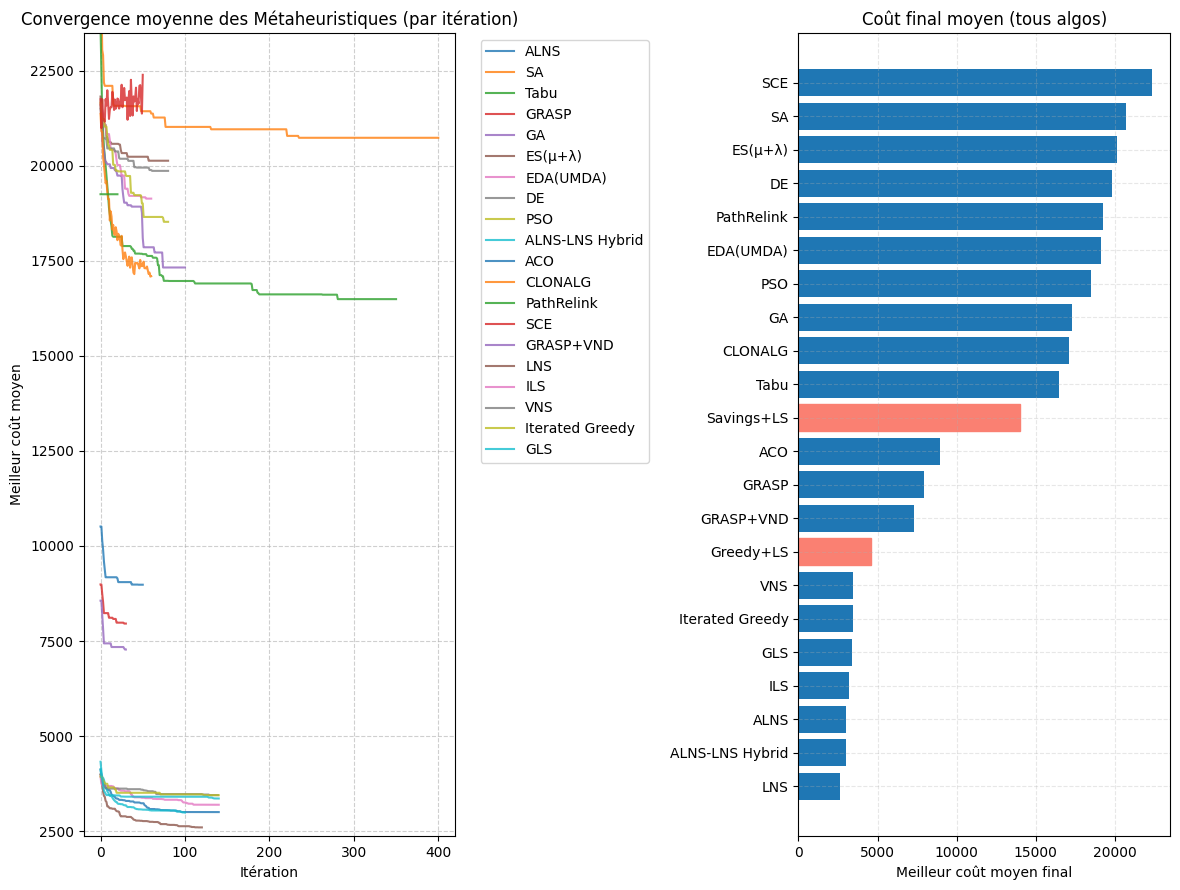

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 9))
all_costs_list = []
mean_histories = {}
for name, hlist in histories.items():
    lens = [len(h) for h in hlist]
    if not lens:
        continue

    L_max_algo = max(lens)
    H_padded = []
    for h in hlist:
        padding = np.full(L_max_algo - len(h), h[-1])
        H_padded.append(np.concatenate([h, padding]))

    H = np.array(H_padded)
    m = H.mean(axis=0)
    mean_histories[name] = m
    all_costs_list.extend(m)

all_costs = np.array(all_costs_list)
q95 = np.quantile(all_costs, 0.95)
q01 = np.quantile(all_costs, 0.01)
y_max_limit = q95 * 1.1
y_min_limit = q01 * 0.9

baseline_algos = ["Savings+LS", "Greedy+LS"]
plt.subplot(1, 2, 1)

for name, m in mean_histories.items():
    if name not in baseline_algos and len(m) > 2:
        plt.plot(m, label=name, alpha=0.8)

plt.title("Convergence moyenne des Métaheuristiques (par itération)")
plt.xlabel("Itération")
plt.ylabel("Meilleur coût moyen")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(bottom=y_min_limit, top=y_max_limit)
plt.grid(True, linestyle="--", alpha=0.6)

plt.subplot(1, 2, 2)
final_costs = {name: m[-1] for name, m in mean_histories.items()}
sorted_costs = sorted(final_costs.items(), key=lambda item: item[1])
algo_names = [item[0] for item in sorted_costs]
algo_values = [item[1] for item in sorted_costs]

bars = plt.barh(algo_names, algo_values)
plt.title("Coût final moyen (tous algos)")
plt.xlabel("Meilleur coût moyen final")
plt.grid(True, linestyle="--", alpha=0.3)

for i, bar in enumerate(bars):
    if algo_names[i] in baseline_algos:
        bar.set_color("salmon")

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## 9. Classement par ratio

In [32]:
ranked = df_results.sort_values(["ratio_score","gap","best","time_s"]).reset_index(drop=True)
ranked.head(10)

,run,algo,best,time_s,gap,iters,iters_per_s,time_norm,gap_norm,value_norm,iters_inv_norm,ratio_score
0,3,ALNS-LNS Hybrid,3042.570023,6.329290,0.097617,100,15.799561,0.119932,0.011456,0.033475,0.998829,0.290923
1,3,GLS,3277.960937,6.128673,0.182535,140,22.843445,0.116112,0.021422,0.045145,0.998303,0.295245
2,2,ALNS-LNS Hybrid,2970.670386,7.053126,0.254870,100,14.178110,0.133712,0.029911,0.029911,0.998950,0.298121
3,1,ALNS-LNS Hybrid,2958.024344,8.530385,0.110149,100,11.722800,0.161837,0.012927,0.029284,0.999133,0.300795
4,2,GLS,3079.024149,7.554733,0.300641,140,18.531430,0.143262,0.035282,0.035282,0.998625,0.303113
5,3,ALNS,3092.451313,9.573622,0.115612,140,14.623514,0.181699,0.013568,0.035948,0.998917,0.307533
6,1,ALNS,3000.557552,10.208102,0.126112,140,13.714597,0.193779,0.014800,0.031393,0.998985,0.309739
7,2,ALNS,2918.049946,12.909979,0.232642,140,10.844324,0.245219,0.027302,0.027302,0.999199,0.324756
8,3,Greedy+LS,4427.705520,8.074749,0.597309,1,0.123843,0.153163,0.070099,0.102142,1.000000,0.331351
9,1,VNS,3305.347969,13.355660,0.240500,139,10.407573,0.253704,0.028225,0.046502,0.999232,0.331916


## 10. Certification

In [33]:
def certify_solution(routes, instance: Instance, D: np.ndarray) -> Dict[str, Any]:
    import numpy as np
    def _normalize_routes(routes_in):
        if isinstance(routes_in, np.ndarray): routes_in = routes_in.tolist()
        if routes_in is None: return []
        if isinstance(routes_in, (list, tuple)) and (len(routes_in)==0 or isinstance(routes_in[0], (int, np.integer))):
            seq=list(map(int, routes_in)); out=[]; cur=[]
            for x in seq:
                if x==0:
                    if cur: out.append(cur); cur=[]
                else:
                    cur.append(x)
            if cur: out.append(cur)
            return out
        out=[]
        for r in routes_in:
            if isinstance(r, np.ndarray): r=r.tolist()
            if isinstance(r, (list, tuple)):
                if len(r)==0: out.append([])
                elif isinstance(r[0], (int, np.integer)): out.append(list(map(int, r)))
                else: out.append([int(x) for x in r])
            elif isinstance(r, (int, np.integer)):
                out.append([int(r)])
            else:
                out.append([int(r)])
        return out
    cert={"valid":True,"errors":[],"checks":{},"total_cost":0.0,"statistics":{"total_routes":0,"total_clients":0,"total_demand":0.0,"max_route_length":0},"route_details":[]}
    try:
        routes=_normalize_routes(routes)
        cert["statistics"]["total_routes"]=len(routes)
        visits={}
        for r in routes:
            cert["statistics"]["max_route_length"]=max(cert["statistics"]["max_route_length"],len(r))
            for c in r:
                if c!=0: visits[c]=visits.get(c,0)+1
        n=len(instance.customers)-1
        distinct=set(visits.keys())
        cert["statistics"]["total_clients"]=len(distinct)
        cover=(len(distinct)==n)
        uniq=all(v==1 for v in visits.values()) and cover
        cert["checks"]["clients_coverage"]=cover
        cert["checks"]["clients_uniqueness"]=uniq
        missing=sorted(set(range(1,n+1))-distinct)
        if missing: cert["errors"].append(f"Clients non visités: {missing}")
        multiple=sorted([c for c,v in visits.items() if v>1])
        if multiple: cert["errors"].append(f"Clients visités plusieurs fois: {multiple}")
        cap=instance.capacity
        depot=0; total_dist=0.0; details=[]; all_cap_ok=True; all_tw_ok=True
        for i,r in enumerate(routes):
            if not r:
                details.append({"route_id":i,"cost":0.0,"clients":r,"length":0, "load": 0.0, "cap_ok": True, "tw_ok": True, "total_time": 0.0})
                continue
            # Vérification capacité
            load=sum(instance.customers[c].demand for c in r if c!=0)
            cert["statistics"]["total_demand"]+=load
            cap_ok=(load<=cap)
            cert["checks"][f"route_{i}_capacity"]=cap_ok
            if not cap_ok: 
                all_cap_ok=False
                cert["errors"].append(f"Route {i}: capacité dépassée ({load}>{cap})")
            
            # Vérification TW et calcul coût distance
            cur=depot; t=0.0; route_dist=0.0
            tw_ok = True
            for cust_id in r:
                travel = float(D[cur, cust_id])
                t += travel
                route_dist += travel
                c = instance.customers[cust_id]
                if t < c.ready: t = c.ready # Attente
                if t > c.due: tw_ok = False # En retard
                t += c.service
                cur = cust_id
            
            # Retour au dépôt
            travel_depot = float(D[cur, depot])
            t += travel_depot
            route_dist += travel_depot
            if t > instance.customers[depot].due: tw_ok = False # Retour dépôt en retard
            
            cert["checks"][f"route_{i}_timewindow"]=tw_ok
            if not tw_ok:
                all_tw_ok = False
                cert["errors"].append(f"Route {i}: violation fenêtre de temps")
            
            details.append({"route_id":i, "cost":route_dist, "clients":r, "length":len(r), "load": load, "cap_ok": cap_ok, "tw_ok": tw_ok, "total_time": t})
            total_dist += route_dist
            
        cert["total_cost"]=float(total_dist)
        cert["checks"]["all_capacity_ok"] = all_cap_ok
        cert["checks"]["all_tw_ok"] = all_tw_ok
        cert["route_details"]=details
    except Exception as e:
        cert["valid"]=False; cert["errors"].append(f"Erreur certification: {e}")
    cert["valid"]=(len(cert["errors"])==0)
    return cert

## 11. Certification des meilleures solutions par algorithme

In [34]:
best_by_algo = (
    df_results.sort_values(["algo", "best"]).groupby("algo").first().reset_index()
)
cert_rows = []
for _, row in best_by_algo.iterrows():
    algo = row["algo"]
    out = ALGOS[algo]()
    keys = out[0] if isinstance(out, tuple) else out
    try:
        routes, _, _, _ = decode(np.asarray(keys, dtype=float), inst, D)
    except Exception:
        routes = greedy_construct(inst, D)
    cert = certify_solution(routes, inst, D)
    cert_rows.append(
        {
            "algo": algo,
            "valid": cert["valid"],
            "total_cost": cert["total_cost"],
            "errors": "; ".join(cert["errors"]) if cert["errors"] else "",
        }
    )
cert_df = (
    pd.DataFrame(cert_rows)
    .sort_values(["valid", "total_cost"], ascending=[False, True])
    .reset_index(drop=True)
)
display(cert_df)

,algo,valid,total_cost,errors
0,LNS,False,1398.159687,Route 0: violation fenêtre de temps; Route 1: ...
1,ALNS,False,1449.984570,Route 0: violation fenêtre de temps; Route 1: ...
2,ILS,False,1476.920797,Route 0: violation fenêtre de temps; Route 1: ...
3,ALNS-LNS Hybrid,False,1493.763148,Route 0: violation fenêtre de temps; Route 1: ...
4,Greedy+LS,False,1561.431447,Route 0: violation fenêtre de temps; Route 1: ...
5,GRASP+VND,False,1574.914472,Route 0: violation fenêtre de temps; Route 1: ...
6,Iterated Greedy,False,1591.725142,Route 0: violation fenêtre de temps; Route 1: ...
7,VNS,False,1648.539497,Route 0: violation fenêtre de temps; Route 1: ...
8,GLS,False,1650.956454,Route 0: violation fenêtre de temps; Route 1: ...
9,GRASP,False,1705.191159,Route 0: violation fenêtre de temps; Route 1: ...


## 12. Visualisation de la meilleure solution globale

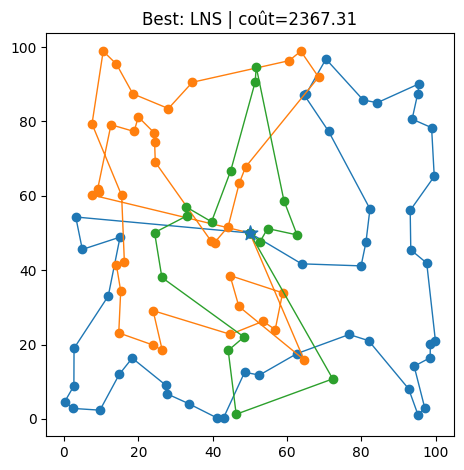

: 

In [ ]:
best_row = df_results.sort_values(["best", "time_s"]).iloc[0]
algo = best_row["algo"]
out = ALGOS[algo]()
keys = out[0] if isinstance(out, tuple) else out
try:
    routes, _, _, _ = decode(np.asarray(keys, dtype=float), inst, D)
except Exception:
    routes = greedy_construct(inst, D)
plt.figure()
for r in routes:
    xs = (
        [inst.customers[0].x] + [inst.customers[i].x for i in r] + [inst.customers[0].x]
    )
    ys = (
        [inst.customers[0].y] + [inst.customers[i].y for i in r] + [inst.customers[0].y]
    )
    plt.plot(xs, ys, marker="o", linewidth=1)
plt.scatter([inst.customers[0].x], [inst.customers[0].y], s=120, marker="*", zorder=5)
plt.title(f"Best: {algo} | coût={best_row['best']:.2f}")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()